In [1]:
import os
import glob
import numpy as np
import pandas as pd
from obspy import UTCDateTime, read, Stream
import matplotlib.pyplot as plt

project_dir = '..'
ppick_dir = f'{project_dir}/results/phasenet_diting_others/phasenet_files'
waveform_dir = f'{project_dir}/data/eq_data/2_waveforms'

ppick_file = f'{ppick_dir}/diting_phasenet_pyrocko_3d_grid.csv' 
pyrocko_markers = f'../results/phasenet_diting_others/00_47_all_picks_PN_PR_DT.txt'

print(ppick_dir)
print("marker path", pyrocko_markers)

../results/phasenet_diting_others/phasenet_files
marker path ../results/phasenet_diting_others/00_47_all_picks_PN_PR_DT.txt


Convert PyRocko picks into phasenet format csv file

In [2]:
# mseed_list = os.listdir(waveform_dir)
mseed_list = pd.read_csv(f'{ppick_dir}/../mseed_list_47.csv').fname.to_list()

# selected event
sel_ev = 'nc73783911.mseed'

# read the ppick file (includes phasenet, diting, pyrocko picks)
pol_df = pd.read_csv(ppick_file, parse_dates=['phase_time', 'pyrocko_phase_time'])

## Function

In [64]:
def plotWFpick_subplots(mseed_file, pol_df, waveform_dir, n_subplots=10, slice_len=0.5):
    # subset the df for this event only
    event_df = pol_df[pol_df['file_name'] == mseed_file]

    # check if the pyrocko col is empty or not [max should be 1]
    if event_df['pyrocko_polarity'].max() != 1:
        print(f'No pyrocko phase for {mseed_file}')
        return None

    ### cleanup the dataframe ###
    # drop rows with empty pyrocko phase_time [naT] and empty phasenet phase_time
    event_df = event_df.dropna(subset=['phase_time', 'pyrocko_phase_time']).reset_index(drop=True)

    # drop rows if time difference between phasenet and pyrocko is more than 2 seconds
    event_df['time_diff'] = (event_df['pyrocko_phase_time'] - event_df['phase_time']).dt.total_seconds()
    event_df = event_df[event_df['time_diff'].abs() <= 2].reset_index(drop=True)

    # read the mseed file
    st = read(f'{waveform_dir}/{mseed_file}')

    fig, axs = plt.subplots(n_subplots, 2, figsize=(10, 1.*n_subplots))

    for i, row in event_df.iterrows():

        pn_pick = UTCDateTime(pd.to_datetime(str(row['phase_time'])))
        pr_pick = UTCDateTime(pd.to_datetime(str(row['pyrocko_phase_time'])))
        
        stn_id = f'{row.station_id}Z'

        # use the WFprocessing function to get the trace
        tr = WFprocessing(stn_id, pn_pick, st, slice_len)

        if not len(tr.data) > 0: # check if the trace is empty
            continue

        # Generate time axis as a numpy array
        times = np.linspace(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.npts)

        # get the pick time from starttime into ms
        pn_pick_time = (pn_pick - tr.stats.starttime)
        pr_pick_time = (pr_pick - tr.stats.starttime)
        
        # get polarity
        dting_pol = row.diting_polarity
        dting_sharp = row.diting_sharpness
        prk_pol = row.pyrocko_polarity

        # easier subplot axes
        ax1, ax2 = axs[i, 0], axs[i, 1]


        ###### COLUMN 1: PhasesNet pick, DiTing polarity ######
        #######################################################
        # plot the waveform
        ax1.plot(times, tr.data, 'k') 

        # PhasesNet pick  
        ax1.axvline(x=pn_pick_time, color='r', linestyle='--')  

        # DiTing Polarity and sharpness
        ax1.text(
            pn_pick_time-0.2, tr.data.max()*0.5, 
            f"{dting_pol} / {dting_sharp}", 
            fontsize=12, color='b', ha='left')
        
        # Title [station_id] and horizontal line at 0
        ax1.set_title(
            f"{tr.id}",loc='left', 
            x=0.01, y=0.6, 
            fontsize=10,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, pad=0.1))

        # Horizontal line at 0
        ax1.axhline(y=0, color='k', lw=0.5)

        # hide x tick labels for this column except the last one
        if i != n_subplots-1:
            ax1.set_xticklabels([])
            ax1.set_xticks([])

        # ax1.spines['right'].set_visible(False)


        ###### COLUMN 2: Pyrocko pick, Pyrocko polarity ######
        #######################################################
        ax2.plot(times, tr.data, 'k')
        ax2.axvline(x=pr_pick_time, color='b', linestyle='--')           # Pyrocko pick [manual + phasenet]
        ax2.text(
            pn_pick_time-0.25, tr.data.max()*0.5,
            f"{'U' if prk_pol == 1 else 'D'}", 
            fontsize=12, color='r',) # polarity

        # horizontal line at 0
        ax2.axhline(y=0, color='k', lw=0.5)
        # hide x and y axis tick labels for this column
        ax2.set_yticklabels([])
        # move y axis ticks to the right
        ax2.yaxis.tick_right()
        if i != n_subplots-1:
            ax2.set_xticklabels([])
            ax2.set_xticks([])
        
        # # hide the left spine
        # ax2.spines['left'].set_visible(False)

        if i == n_subplots-1:
            # stop the loop if the last subplot is reached
            break

    # add one title for each column
    axs[0, 0].set_title('PhasesNet and DiTingMotion', fontsize=14)
    axs[0, 1].set_title('Pyrocko and Phasenet', fontsize=14)

    # axis titles for the whole figure
    fig.text(0.5, -0.01, 'Time [s]', ha='center', fontsize=14)
    fig.text(-0.01, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize=14)

    fig.subplots_adjust(wspace=0.1)
    fig.tight_layout()     

    return fig


In [65]:
def WFprocessing(
    stn_id : str,
    pn_pick : UTCDateTime,
    st : Stream,
    sli : float = 0.5
):
    """ 
    Check for empty trace, detrend, taper, filter.
    Slice the trace around the PhasesNet pick.

    output: trace
    """ 
    ist = st.select(id=stn_id)
    tr = ist[0].copy()

    # check for empty trace
    if len(tr.data) > 0:
        tr.detrend('demean')
        try:
            tr.detrend('linear')
        except:
            tr.detrend('constant')
        
        try:
            tr.taper(0.001)
            tr.filter('bandpass', freqmin=.1, freqmax=10, corners=4, zerophase=True)  # Apply a bandpass filter
        except:
            pass
        
        tr = tr.slice(pn_pick - sli-0.01, pn_pick + sli) # around PhasesNet pick

        return tr
         



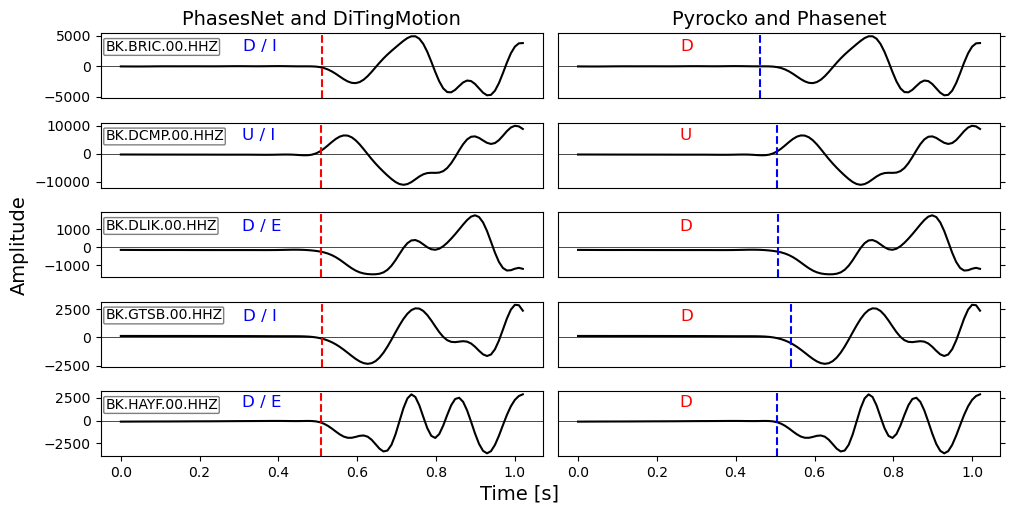

In [66]:
fig = plotWFpick_subplots(sel_ev, pol_df, waveform_dir, n_subplots=5, slice_len=0.5)

plt.tight_layout()
plt.show()  

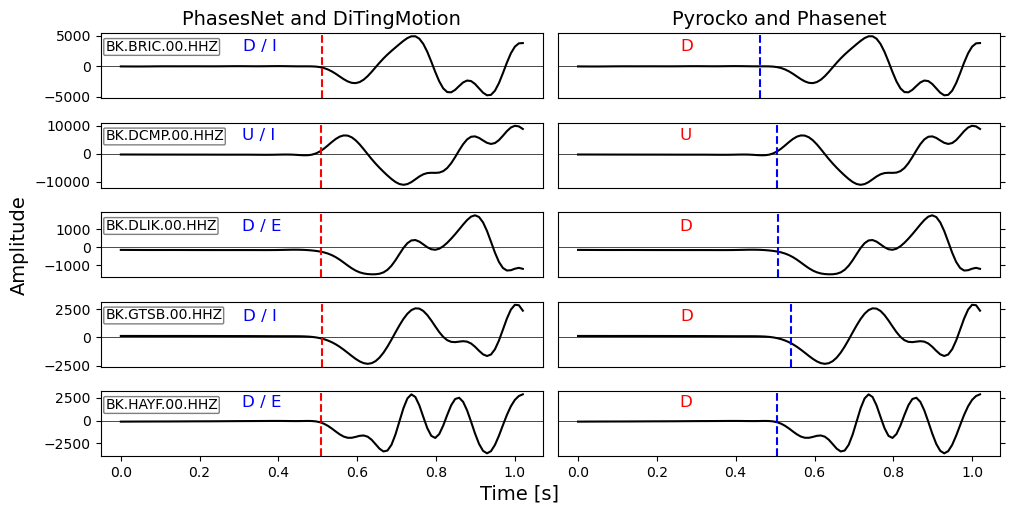

In [5]:
from my_funcs.my_class_funcs import WaveformPlotter
%reload_ext autoreload
%autoreload 2
wfp = WaveformPlotter()

fig = wfp.plotWFpick_subplots(sel_ev, pol_df, waveform_dir, n_subplots=5, slice_len=0.5)
plt.tight_layout()
plt.show()  

# original plotter

Processing nc73783911.mseed


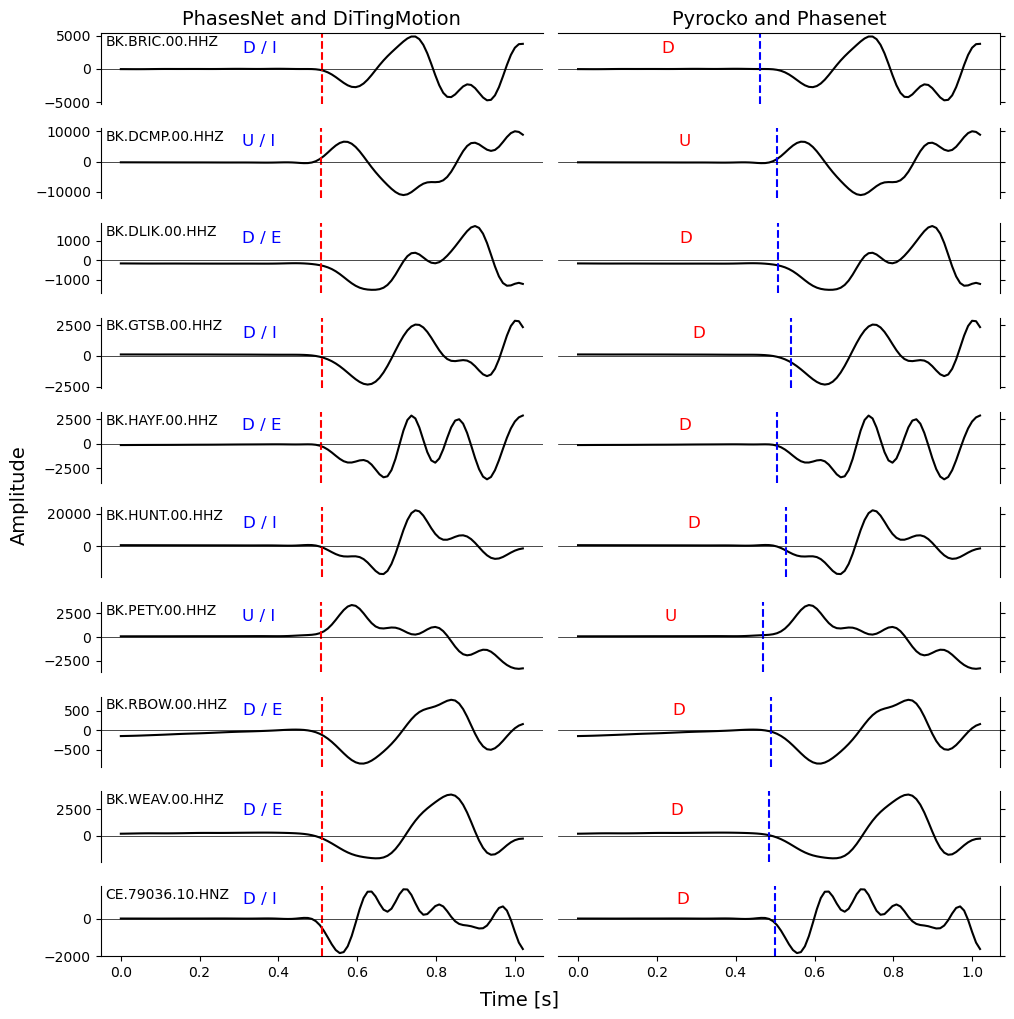

In [120]:
for mseed_file in mseed_list:
    if mseed_file != sel_ev: continue # sel_ev = 'nc73783911.mseed'

    # subset the df for this event only
    event_df = pol_df[pol_df['file_name'] == mseed_file]

    # check if the pyrocko col is empty or not [max should be 1]
    if event_df['pyrocko_polarity'].max() != 1:
        print(f'No pyrocko phase for {mseed_file}')
        continue

    print(f'Processing {mseed_file}')
    ### read the mseed file
    st = read(f'{waveform_dir}/{mseed_file}')

    ### cleanup the dataframe ###
    # drop rows with empty pyrocko phase_time [naT] and empty phasenet phase_time
    event_df = event_df.dropna(subset=['phase_time', 'pyrocko_phase_time']).reset_index(drop=True)

    # drop rows if time difference between phasenet and pyrocko is more than 2 seconds
    event_df['time_diff'] = (event_df['pyrocko_phase_time'] - event_df['phase_time']).dt.total_seconds()
    event_df = event_df[event_df['time_diff'].abs() <= 2].reset_index(drop=True)

    n_subplots = 10 # len(event_df)
    fig, axs = plt.subplots(n_subplots, 2, figsize=(10, 1.*n_subplots))

    for i, row in event_df[0:10].iterrows():

        pn_pick = UTCDateTime(pd.to_datetime(str(row['phase_time'])))
        pr_pick = UTCDateTime(pd.to_datetime(str(row['pyrocko_phase_time'])))
        
        stn_id = f'{row.station_id}Z'
        ist = st.select(id=stn_id)
        tr = ist[0].copy()
        

        # check for empty trace
        if len(tr.data) > 0:
            tr.detrend('demean')
            try:
                tr.detrend('linear')
            except:
                tr.detrend('constant')
            
            try:
                tr.taper(0.001)
                tr.filter('bandpass', freqmin=.1, freqmax=10, corners=4, zerophase=True)  # Apply a bandpass filter
            except:
                pass
            
            # slice the trace
            sli = 0.5
            # tr2 = tr.copy()
            tr = tr.slice(pn_pick - sli-0.01, pn_pick + sli) # around PhasesNet pick
            # tr2 = tr2.slice(pr_pick - sli-0.01, pr_pick + sli) # around Pyrocko pick [manual polarity]
            
            if not len(tr.data) > 0: # check if the trace is empty
                continue
        
        
            # Generate time axis as a numpy array
            times = np.linspace(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.npts)

            # get the pick time from starttime into ms
            pn_pick_time = (pn_pick - tr.stats.starttime)
            pr_pick_time = (pr_pick - tr.stats.starttime)
            
            # get polarity
            dting_pol = row.diting_polarity
            dting_sharp = row.diting_sharpness
            prk_pol = row.pyrocko_polarity
            

            ## plot PhasesNet pick on column 1 ##

            axs[i, 0].plot(times, tr.data, 'k')                                 # plot the waveform
            axs[i, 0].axvline(x=pn_pick_time, color='r', linestyle='--')            # PhasesNet pick
            axs[i, 0].text(
                pn_pick_time-0.2, tr.data.max()*0.5, 
                f"{dting_pol} / {dting_sharp}", 
                fontsize=12, color='b', ha='left')

            # title [station_id] and horizontal line at 0
            axs[i, 0].set_title(
                f"{tr.id}", 
                loc='left', x=0.01,
                y=0.7, fontsize=10)
            axs[i, 0].axhline(y=0, color='k', lw=0.5)
            # hide x tick labels for this column except the last one
            if i != n_subplots-1:
                # hide tick labels
                axs[i, 0].set_xticklabels([])
                # hide ticks
                axs[i, 0].set_xticks([])
            # # hide the top, bottom, right spines
            # if not i == 0 and i != n_subplots-1:
            #     axs[i, 0].spines['top'].set_visible(False)
            #     axs[i, 0].spines['bottom'].set_visible(False)
            # elif i == 0: axs[i, 0].spines['bottom'].set_visible(False)
            # elif i == n_subplots-1: axs[i, 0].spines['top'].set_visible(False)
            axs[i, 0].spines['right'].set_visible(False)

            

            ## plot Pyrocko pick on column 2 ##

            axs[i, 1].plot(times, tr.data, 'k')
            axs[i, 1].axvline(x=pr_pick_time, color='b', linestyle='--')           # Pyrocko pick [manual + phasenet]
            axs[i, 1].text(
                pr_pick_time-0.25, tr.data.max()*0.5,
                f"{'U' if prk_pol == 1 else 'D'}", 
                fontsize=12, color='r',) # polarity

            # title [station_id] and horizontal line at 0
            axs[i, 1].axhline(y=0, color='k', lw=0.5)
            # hide x and y axis tick labels for this column
            axs[i, 1].set_yticklabels([])
            # move y axis ticks to the right
            axs[i, 1].yaxis.tick_right()
            if i != n_subplots-1:
                axs[i, 1].set_xticklabels([])
                axs[i, 1].set_xticks([])
            
            # # hide the top, bottom, right spines
            # axs[i, 1].spines['top'].set_visible(False)
            axs[i, 1].spines['left'].set_visible(False)
            # axs[i, 1].spines['bottom'].set_visible(False)
            
        
        else:
            continue # mention continue, otherwise it will `pass`
    
    # add one title for each column
    axs[0, 0].set_title('PhasesNet and DiTingMotion', fontsize=14)
    axs[0, 1].set_title('Pyrocko and Phasenet', fontsize=14)

    # axis titles for the whole figure
    fig.text(0.5, -0.01, 'Time [s]', ha='center', fontsize=14)
    fig.text(-0.01, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize=14)

    # remove the box around the plot
    for i, ax in enumerate(axs.flatten()):
        if i != 0 and i != 1:
            ax.spines['top'].set_visible(False)
        if i != len(axs.flatten())-1 and i != len(axs.flatten())-2:
            ax.spines['bottom'].set_visible(False)
        # ax.spines['right'].set_visible(False)
        # ax.spines['left'].set_visible(False)
    
    # draw a line between the two columns
    fig.subplots_adjust(wspace=0.1)
            
    plt.tight_layout()
    plt.show()
            
    break
    

Processing nc73783911.mseed


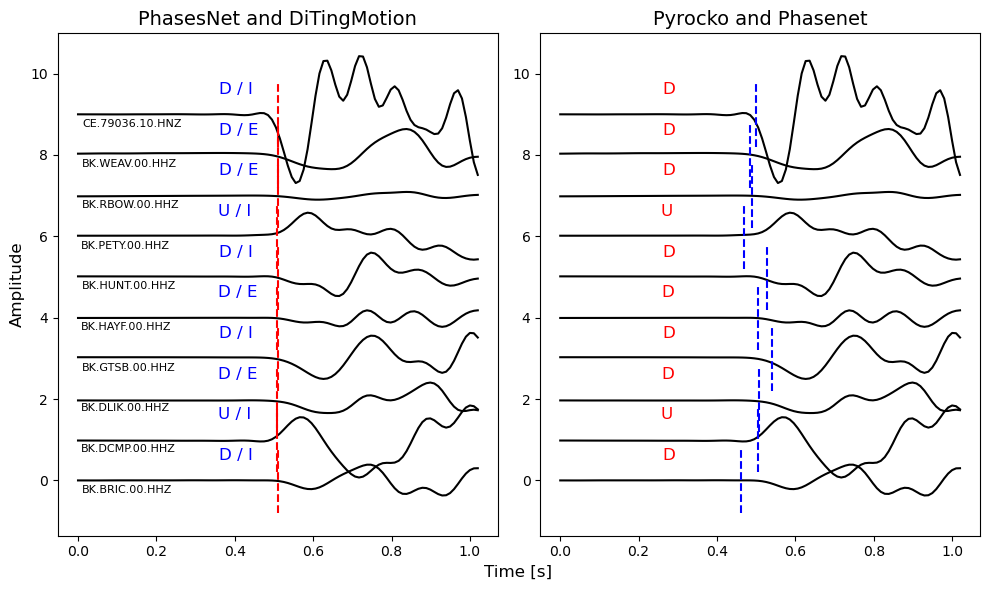

In [72]:
for mseed_file in mseed_list:
    mseed_file = 'nc73783911.mseed'

    # subset the df for this event only
    event_df = pol_df[pol_df['file_name'] == mseed_file]

    # check if the pyrocko col is empty or not [max should be 1]
    if event_df['pyrocko_polarity'].max() != 1:
        print(f'No pyrocko phase for {mseed_file}')
        continue

    ### cleanup the dataframe ###
    # drop rows with empty pyrocko phase_time [naT] and empty phasenet phase_time
    event_df = event_df.dropna(subset=['phase_time', 'pyrocko_phase_time']).reset_index(drop=True)

    # drop rows if time difference between phasenet and pyrocko is more than 2 seconds
    event_df['time_diff'] = (event_df['pyrocko_phase_time'] - event_df['phase_time']).dt.total_seconds()
    event_df = event_df[event_df['time_diff'].abs() <= 2].reset_index(drop=True)

    print(f'Processing {mseed_file}')
    ### read the mseed file
    st = read(f'{waveform_dir}/{mseed_file}')

    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    ax1, ax2 = axs

    for i, row in event_df[0:10].iterrows():

        # get the pick times (PhasesNet and Pyrocko)
        pn_pick = UTCDateTime(pd.to_datetime(str(row['phase_time'])))
        pr_pick = UTCDateTime(pd.to_datetime(str(row['pyrocko_phase_time'])))
        
        # get the trace for this station
        ist = st.select(id=f'{row.station_id}Z')
        tr = ist[0].copy()
    
        # check for empty trace
        if len(tr.data) > 0:
            tr.detrend('demean')
            try:
                tr.detrend('linear')
            except:
                tr.detrend('constant')
            
            try:
                tr.taper(0.001)
                tr.filter('bandpass', freqmin=.1, freqmax=10, corners=4, zerophase=True)  # Apply a bandpass filter
            except:
                pass
            
            tr.data = tr.data/np.max(tr.data) # normalize the trace
            # slice the trace
            sli = 0.5
            tr = tr.slice(pn_pick - sli-0.01, pn_pick + sli) # around PhasesNet pick
            
            if not len(tr.data) > 0: # check if the trace is empty
                continue
        
        
            # Generate time axis as a numpy array
            times = np.linspace(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.npts) # time [s]

            # get the pick time from starttime into seconds
            pn_pick_time = ((pn_pick - tr.stats.starttime)) # * tr.stats.sampling_rate)
            pr_pick_time = ((pr_pick - tr.stats.starttime)) # * tr.stats.sampling_rate)
            
            # get polarity
            dting_pol = row.diting_polarity
            dting_sharp = row.diting_sharpness
            prk_pol = row.pyrocko_polarity
            
            ## plot PhasesNet pick on column 1 ##
            # plot with y-axis compressed to 1 cm above and below
            ax1.plot(times, tr.data*3 + i, 'k') # plot the waveform
            
            ax1.plot([pn_pick_time, pn_pick_time], [i-0.8, i+0.8], color='r', ls='--')            # PhasesNet pick
            # Polarity and sharpness
            ax1.text(
                pn_pick_time-0.15, i + 0.5, 
                f"{dting_pol} / {dting_sharp}", 
                fontsize=12, color='b', ha='left')

            # title [station_id] and horizontal line at 0
            ax1.text( 
                pn_pick_time-0.5,
                i - 0.3, 
                f"{tr.id}",
                fontsize=8)
            # axs1.axhline(y=0, color='k', lw=0.5)
            

            # ## plot Pyrocko pick on column 2 ##

            ax2.plot(times, tr.data * 3 +i, 'k')
            ax2.plot([pr_pick_time, pr_pick_time], [i-0.8, i+0.8], color='b', ls='--')           # Pyrocko pick [manual + phasenet]
            ax2.text(
                pn_pick_time-0.25,  i + 0.5,
                f"{'U' if prk_pol == 1 else 'D'}", 
                fontsize=12, color='r',)

            # ax2.axhline(y=0, color='k', lw=0.5)
        
        else:
            continue # mention continue, otherwise it will `pass`

    # # add one title for each column
    ax1.set_title('PhasesNet and DiTingMotion', fontsize=14)
    ax2.set_title('Pyrocko and Phasenet', fontsize=14)
    
    # plot axes (one for both columns)
    ax1.set_ylabel('Amplitude', fontsize=12)
    plt.xlabel('Time [s]',x=-.05, y=0.01, fontsize=12)
        

    
    plt.tight_layout()
    plt.show()
            
    break
    

In [ ]:
def WFprocessing(
    stn_id : str,
    pn_pick : UTCDateTime,
    st : Stream,
    sli : float = 0.5,
    normalize : bool = False,
):
    """ 
    Check for empty trace, detrend, taper, filter.
    Slice the trace around the PhasesNet pick.

    output: trace
    """ 
    ist = st.select(id=stn_id)
    tr = ist[0].copy()

    # check for empty trace
    if len(tr.data) > 0:
        tr.detrend('demean')
        try:
            tr.detrend('linear')
        except:
            tr.detrend('constant')
        
        try:
            tr.taper(0.001)
            tr.filter('bandpass', freqmin=.1, freqmax=10, corners=4, zerophase=True)  # Apply a bandpass filter
        except:
            pass
        
        if normalize:
            tr.data = tr.data/np.max(tr.data)
        # slice the trace
        tr = tr.slice(pn_pick - sli-0.01, pn_pick + sli) # around PhasesNet pick

        return tr

In [ ]:
def plotWFpick_oneplot(
                        mseed_file = None,
                        pol_df = None,
                        waveform_dir = None,
                        n_subplots=10, 
                        slice_len=0.5,
                        zoom=3,
                        normalize: bool = True
                        ):

    # subset the df for this event only
    event_df = pol_df[pol_df['file_name'] == mseed_file]

    # check if the pyrocko col is empty or not [max should be 1]
    if event_df['pyrocko_polarity'].max() != 1:
        print(f'No pyrocko phase for {mseed_file}')
        return None

    ### cleanup the dataframe ###
    # drop rows with empty pyrocko phase_time [naT] and empty phasenet phase_time
    event_df = event_df.dropna(subset=['phase_time', 'pyrocko_phase_time']).reset_index(drop=True)

    # drop rows if time difference between phasenet and pyrocko is more than 2 seconds
    event_df['time_diff'] = (event_df['pyrocko_phase_time'] - event_df['phase_time']).dt.total_seconds()
    event_df = event_df[event_df['time_diff'].abs() <= 2].reset_index(drop=True)

    # read the mseed file
    st = read(f'{waveform_dir}/{mseed_file}')

    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    ax1, ax2 = axs

    for i, row in event_df[0:n_subplots].iterrows():

        # get the pick times (PhasesNet and Pyrocko)
        pn_pick = UTCDateTime(pd.to_datetime(str(row['phase_time'])))
        pr_pick = UTCDateTime(pd.to_datetime(str(row['pyrocko_phase_time'])))
        
        # get the trace for this station
        stn_id = f'{row.station_id}Z'

        # Process the waveform using the WFprocessing function
        tr = WFprocessing(stn_id, pn_pick, st, slice_len, normalize)
        
        if not len(tr.data) > 0: # check if the trace is empty
            continue
    
        # Generate time axis as a numpy array
        times = np.linspace(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.npts) # time [s]

        # get the pick time from starttime into seconds
        pn_pick_time = ((pn_pick - tr.stats.starttime)) 
        pr_pick_time = ((pr_pick - tr.stats.starttime)) 
        
        # get polarity
        dting_pol = row.diting_polarity
        dting_sharp = row.diting_sharpness
        prk_pol = row.pyrocko_polarity
        
        ###### COLUMN 1: PhasesNet pick, DiTing polarity ######
        #######################################################
        ax1.plot(times, tr.data*zoom + i, 'k')     # plot the waveform
        ax1.plot([pn_pick_time, pn_pick_time], [i-0.8, i+0.8], color='r', ls='--')      # PhasesNet pick
        # Polarity and sharpness (DiTing)
        ax1.text(
            pn_pick_time-0.15, i + 0.5, 
            f"{dting_pol} / {dting_sharp}", 
            fontsize=12, color='b', ha='left')

        # title [station_id] and horizontal line at 0
        ax1.text( 
            pn_pick_time-0.5,
            i - 0.3, 
            f"{tr.id}",
            fontsize=8)
        # axs1.axhline(y=0, color='k', lw=0.5)
            

        ###### COLUMN 2: Pyrocko pick, Pyrocko polarity ######
        #######################################################
        ax2.plot(times, tr.data * zoom +i, 'k')    # plot the waveform
        ax2.plot([pr_pick_time, pr_pick_time], [i-0.8, i+0.8], color='b', ls='--')   # Pyrocko pick [manual + phasenet]
        # Polarity (Pyrocko)
        ax2.text(
            pn_pick_time-0.25,  i + 0.5,
            f"{'U' if prk_pol == 1 else 'D'}", 
            fontsize=12, color='r',)

        # ax2.axhline(y=0, color='k', lw=0.5)


    # # add one title for each column
    ax1.set_title('PhasesNet and DiTingMotion', fontsize=14)
    ax2.set_title('Pyrocko and Phasenet', fontsize=14)
    
    # plot axes (one for both columns)
    ax1.set_ylabel('Amplitude', fontsize=12)
    plt.xlabel('Time [s]',x=-.05, y=0.01, fontsize=12)

    return fig    